In [1]:
import os
import pandas as pd 

In [2]:
TRAINING_DATA_PATH = "../data/training.1600000.processed.noemoticon.csv"
CHUNK_SIZE = 150000

df_reader = pd.read_csv(TRAINING_DATA_PATH, names=["label", "id", "timestamp", "unk1", "user_id", "tweet"], encoding="utf-8", encoding_errors="ignore")
# df_reader = pd.read_csv(TRAINING_DATA_PATH, chunksize=CHUNK_SIZE, names=["label", "id", "timestamp", "unk1", "user_id", "tweet"])

In [3]:
df_reader.head()

,label,id,timestamp,unk1,user_id,tweet
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."


In [4]:
df_reader.drop(columns=["id", "timestamp", "unk1", "user_id"], inplace=True)

In [5]:
df_reader.head()

,label,tweet
0,0,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,is upset that he can't update his Facebook by ...
2,0,@Kenichan I dived many times for the ball. Man...
3,0,my whole body feels itchy and like its on fire
4,0,"@nationwideclass no, it's not behaving at all...."


In [6]:
'''
    cleaning 
    1. remove tags, hashtags and urls 
'''
import re

regex_url_matching = "https?://\S+|www.\S+"
regex_userid_matching = "@\S+"
regex_extra_spaces = "\s{2,}"
regex_hashtag = "#\S+"
regex_non_chars_line = "^[\W_]+$"

def clean_row(row):
    row = re.sub(regex_url_matching, ' ', row)
    row = re.sub(regex_userid_matching, ' ', row)
    row = re.sub(regex_hashtag, " ", row)
    row = re.sub(regex_non_chars_line, " ", row)
    row = re.sub(regex_extra_spaces, " ", row)
    row = row.strip()   

    if not row:
        return pd.NA
    
    return row




In [7]:
df_reader["tweet"] = df_reader["tweet"].apply(clean_row)

In [8]:
df_reader.head()

,label,tweet
0,0,"- Awww, that's a bummer. You shoulda got David..."
1,0,is upset that he can't update his Facebook by ...
2,0,I dived many times for the ball. Managed to sa...
3,0,my whole body feels itchy and like its on fire
4,0,"no, it's not behaving at all. i'm mad. why am ..."


In [9]:
df_reader["tweet"].isna().value_counts()

tweet
False    1596503
True        3497
Name: count, dtype: int64

In [40]:
df_reader.dropna(axis="index", inplace=True)

In [42]:
df_reader.to_csv("../data/clean_train_v1.csv", index=False)

In [35]:
len(df_reader)

1600000

In [41]:
len(df_reader)

1596503

In [1]:
import pandas as pd
df = pd.read_csv("../data/clean_train_v1.csv")
df.head()

,label,tweet
0,0,"- Awww, that's a bummer. You shoulda got David..."
1,0,is upset that he can't update his Facebook by ...
2,0,I dived many times for the ball. Managed to sa...
3,0,my whole body feels itchy and like its on fire
4,0,"no, it's not behaving at all. i'm mad. why am ..."


In [2]:
# checking if training data has more than two clusters
import numpy as np
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sentence_transformers import SentenceTransformer

model = SentenceTransformer("thenlper/gte-base")


/Users/junaid.shaikh/Desktop/Personal/sentiment-detection/sentx/.env/lib/python3.10/site-packages/sentence_transformers/cross_encoder/CrossEncoder.py:11: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from tqdm.autonotebook import tqdm, trange


In [3]:
sample = df.sample(frac=0.01, random_state=42)
sentences = sample["tweet"].tolist()


In [4]:
embeddings = model.encode(sentences)

# Reduce dimensions using PCA for visualization
pca = PCA(n_components=10)
embeddings_2d = pca.fit_transform(embeddings)


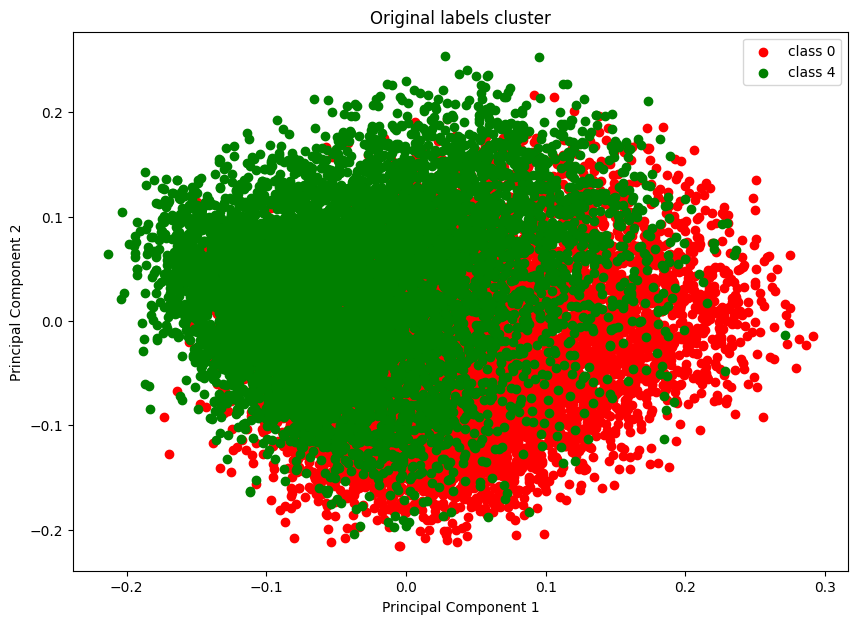

In [5]:
# original label clusters
plt.figure(figsize=(10, 7))
colors = ['r', 'g',]
for i, cls in enumerate([0, 4]):
    points = embeddings_2d[(sample["label"] == cls)]
    plt.scatter(points[:, 0], points[:, 1], c=colors[i], label=f'class {cls}')
    
plt.title('Original labels cluster')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend()
plt.show()

# observation
# lots of labels overlapped with principal components. 

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


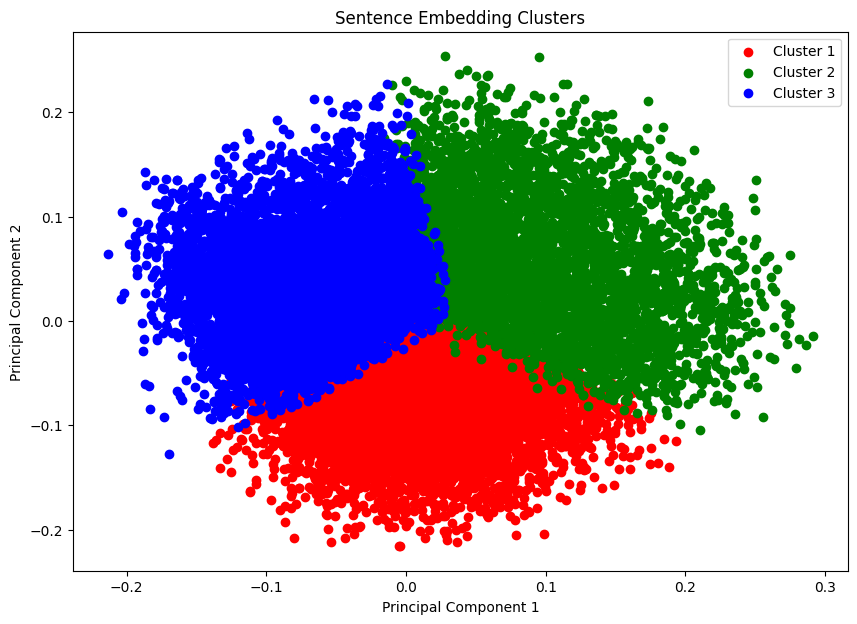

In [6]:
# Checking if data can be clearly segregated into three clusters
# Cluster embeddings using KMeans
num_clusters = 3
kmeans = KMeans(n_clusters=num_clusters, random_state=0)
kmeans.fit(embeddings_2d)
labels = kmeans.labels_

# Plot clusters
plt.figure(figsize=(10, 7))
colors = ['r', 'g', 'b']
for i in range(num_clusters):
    points = embeddings_2d[labels == i]
    plt.scatter(points[:, 0], points[:, 1], c=colors[i], label=f'Cluster {i+1}')
    
plt.title('Sentence Embedding Clusters')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend()
plt.show()

# observation: data can be clearly seperated into three cluster using principal components

In [7]:
# data sampling with cluster labels just to verify
sample[labels == 0].head(25).to_records()

rec.array([( 215275, 0, 'what happened?'),
           ( 433245, 0, "i'm well sad now"),
           ( 578355, 0, 'my camera is nott workingngngngnng. -cries-'),
           ( 249538, 0, 'Carly just dropped my phone, and now it ugly'),
           (  17744, 0, "I'm assuming &quot;getting use 2 braces&quot; means waiting for scar tissue to form around the inside of my lips and cheeks so I can sleep at night"),
           (  58080, 0, 'I miss mommy &amp; daddy!!!'),
           ( 166160, 0, 'So sorry to hear about your mom! that really sucks'),
           ( 909361, 4, "I'm sadly dissapointed in the show ''Jonas''. Good shows on disney= hannah montana &amp; wizards of waverly place."),
           ( 147557, 0, 'thats not good.'),
           ( 723554, 0, 'Going out to meet up with someone this probably wont end well'),
           ( 394610, 0, 'Spending my last few hours with dan. Cant stop crying. I dont want him to go'),
           ( 734098, 0, 'I hate you brain big stupid gay dream. blaaaaah.'

In [8]:
sample[labels == 1].head(25).to_records()

rec.array([(  28474, 0, "don't want to go back to school tomorrow"),
           ( 736969, 0, "raining in NY!, oh shit...then I won't be able to wear all my cool summer tops and skirts then"),
           (  10917, 0, "I'm feeling groggy, sore, and a little sick. Good morning haha! What's the word, Twitter?"),
           ( 941343, 4, "Feeling like I'm ready to be productive this morning! Wow.. and it only too 4 days."),
           (1553037, 4, "Long day. Watched and pick out v-necks. Now I'm crawling into bed before 8:30. Super cool"),
           ( 221485, 0, 'Midnight took a tumble down the basement steps tonight. Ugh. Going to be a long night. Emailing you now.'),
           ( 255691, 0, 'WHY must the weekends go so fast???'),
           (1150128, 4, 'Forgot how boring some Yuma parties were! Coutin down the days till my bestie gets here'),
           (1494039, 4, 'Taking a break from my studies. Sitting in my window watching the horseriders go by I love my city-- diversity in action.'

In [9]:
sample[labels == 2].head(25).to_records()

rec.array([( 875519, 4, 'so the apostles would then include pythagorus, descartes, and capernicus, right?'),
           (1096816, 4, 'yea if u want .all good here.just got make burgers soon.lol'),
           (1592938, 4, 'På byen i Beijing this could get interesting...'),
           ( 907442, 4, 'This cigarette is so relaxing'),
           (1036496, 4, "- Thats so nice of you guys to do that I'm sure the kids were so happy to see you both!"),
           (1522317, 4, "the song of 'back to you' so i am now making a remix back to you baby"),
           (1553959, 4, 'going to go on a turtle walk on the beach cool/breezy and twilighty'),
           (1432343, 4, 'Waiting for my bestie and im so happy im gonna get my tickets to go see and'),
           (1082832, 4, "LOL! Naw, I'm GOOD. I wanna talk to you."),
           (1233380, 4, 'Yeay! Just bought tickets for Tori Amos and Ani DiFranco!'),
           (1548975, 4, '- preety eyes loolz'),
           (1412364, 4, 'Oh man, that made me laugh 

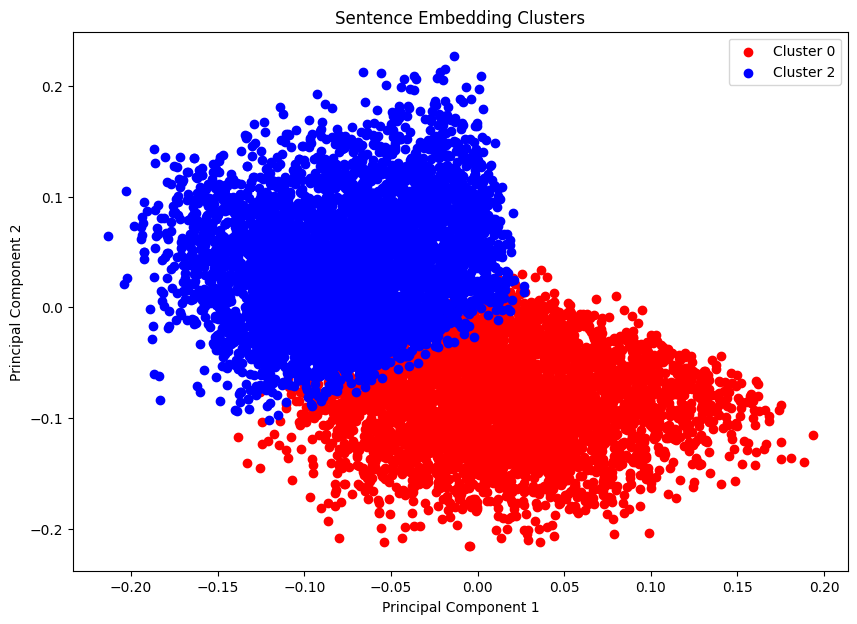

In [10]:
# plotting following points
# original label - 0, cluster 0 (true negatives)
# original label - 4, cluster 2 (true positives)


plt.figure(figsize=(10, 7))
colors = ['r', 'g', 'b']
for original_label, assigned_label in [(0, 0), (4, 2)]:
    points = embeddings_2d[np.logical_and(labels == assigned_label, (sample["label"] == original_label).to_numpy())]
    plt.scatter(points[:, 0], points[:, 1], c=colors[assigned_label], label=f'Cluster {assigned_label}')
    
plt.title('Sentence Embedding Clusters')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend()
plt.show()

# observation: data can be clearly seperated into three cluster using principal components

In [20]:
sample["updated_label"] = "na"
sample["pca2"] = embeddings_2d[:, :2].tolist()

In [30]:
sample.loc[np.logical_and(labels == 0, (sample["label"] == 0).to_numpy()), "updated_label"] = "negative"
sample.loc[np.logical_and(labels == 2, (sample["label"] == 4).to_numpy()), "updated_label"] = "positive"
sample.loc[labels == 1, "updated_label"] = "maybe_neutral"

In [34]:
sample.to_csv("../data/sampled_clean_data.csv", index=False)

In [ ]:
# To identify neutral points
# use exisiting sentiment detection model
# condition of neutral -> pretrained sentiment detection model should predict neutral and should lie in 2nd cluster

In [6]:
import pandas as pd
import json

df_clean = pd.read_csv("../data/sampled_clean_data.csv")
df_clean["pca2"] = df_clean["pca2"].apply(lambda x:json.loads(x))

In [7]:
df_clean[df_clean["updated_label"] == "maybe_neutral"]

,label,tweet,updated_label,pca2
10,0,don't want to go back to school tomorrow,maybe_neutral,"[0.19482046365737915, 0.011594757437705994]"
11,0,"raining in NY!, oh shit...then I won't be able...",maybe_neutral,"[0.08122001588344574, 0.03531705588102341]"
15,0,"I'm feeling groggy, sore, and a little sick. G...",maybe_neutral,"[0.09683387726545334, 0.061873942613601685]"
17,4,Feeling like I'm ready to be productive this m...,maybe_neutral,"[0.11272967606782913, 0.18586592376232147]"
25,4,Long day. Watched and pick out v-necks. Now I'...,maybe_neutral,"[0.08366203308105469, 0.1625971645116806]"
...,...,...,...,...
15958,0,Damn. Cake not out of oven yet. Will have to c...,maybe_neutral,"[0.04114338010549545, 0.05457332730293274]"
15959,4,Have a goodnight sleep. Sweet dreams.,maybe_neutral,"[0.12543272972106934, 0.07209634780883789]"
15960,0,"OMG, when we left the Vernissage, it was down ...",maybe_neutral,"[0.042392171919345856, 0.03081662952899933]"
15962,4,- last minute 3-hour session in the studio...j...,maybe_neutral,"[0.1407676339149475, 0.07219201326370239]"


In [12]:
# Load model directly
from transformers import AutoTokenizer, AutoModelForSequenceClassification

tokenizer = AutoTokenizer.from_pretrained("finiteautomata/bertweet-base-sentiment-analysis")
model = AutoModelForSequenceClassification.from_pretrained("finiteautomata/bertweet-base-sentiment-analysis")

/Users/junaid.shaikh/Desktop/Personal/sentiment-detection/sentx/.env/lib/python3.10/site-packages/huggingface_hub/file_download.py:1150: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
emoji is not installed, thus not converting emoticons or emojis into text. Install emoji: pip3 install emoji==0.6.0


In [13]:
true_neutrals = []

for idx ,row in df_clean[df_clean["updated_label"] == "maybe_neutral"].iterrows():
    inputs = tokenizer(row["tweet"], return_tensors="pt")
    logits = model(**inputs).logits
    predicted_class_id = logits.argmax().item()
    p_cls = model.config.id2label[predicted_class_id]

    if p_cls == "NEU": 
        true_neutrals.append(row.to_dict())

    print(f"row-id: {idx} | class: {p_cls}")
        

row-id: 10 | class: NEG
row-id: 11 | class: NEG
row-id: 15 | class: NEG
row-id: 17 | class: POS
row-id: 25 | class: POS
row-id: 26 | class: NEG
row-id: 27 | class: NEG
row-id: 29 | class: NEG
row-id: 33 | class: POS
row-id: 36 | class: NEU
row-id: 49 | class: POS
row-id: 51 | class: NEU
row-id: 54 | class: POS
row-id: 61 | class: NEG
row-id: 66 | class: NEG
row-id: 68 | class: NEU
row-id: 78 | class: NEU
row-id: 81 | class: NEU
row-id: 84 | class: POS
row-id: 89 | class: NEG
row-id: 91 | class: NEG
row-id: 93 | class: NEU
row-id: 94 | class: POS
row-id: 95 | class: NEU
row-id: 96 | class: POS
row-id: 99 | class: POS
row-id: 100 | class: NEG
row-id: 101 | class: POS
row-id: 110 | class: NEU
row-id: 112 | class: NEG
row-id: 113 | class: NEG
row-id: 117 | class: NEU
row-id: 120 | class: NEU
row-id: 129 | class: NEG
row-id: 130 | class: POS
row-id: 131 | class: NEG
row-id: 133 | class: NEG
row-id: 141 | class: NEG
row-id: 146 | class: NEU
row-id: 147 | class: NEU
row-id: 150 | class: NEU
r

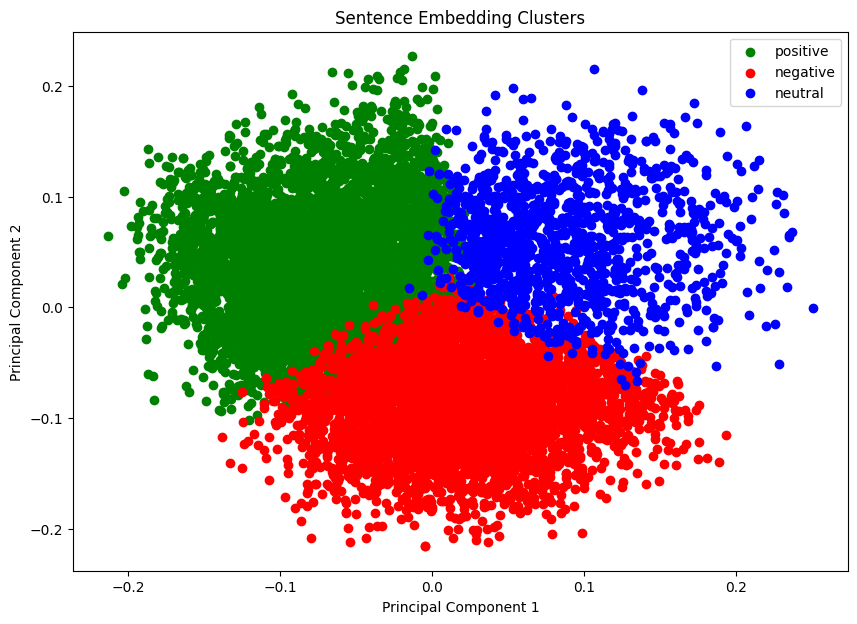

In [25]:
import matplotlib.pyplot as plt
import numpy as np

df_neutral = pd.DataFrame(true_neutrals)

plt.figure(figsize=(10, 7))
colors = ['r', 'g', 'b']
for label, col in [("positive", "g"), ("negative", "r")]:
    points = df_clean[df_clean["updated_label"] == label]["pca2"]
    points = np.stack(points)
    plt.scatter(points[:, 0], points[:, 1], c=col, label=f'{label}')



points = df_neutral["pca2"]
points = np.stack(points)
plt.scatter(points[:, 0], points[:, 1], c='b', label=f'neutral')


plt.title('Sentence Embedding Clusters')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend()
plt.show()